# Asynchronous Bayesian optimization with Trieste

In this notebook we demonstrate Trieste's ability to perform asynchronous Bayesian optimisation, as is suitable for scenarios where the objective function can be run for several points in parallel but where observations might return back at different times. To avoid wasting resources waiting for the evaluation of the whole batch, we immediately request the next point asynchronously, taking into account points that are still being evaluated. Besides saving resources, asynchronous approach also can potentially [improve sample efficiency](https://arxiv.org/abs/1901.10452) in comparison with synchronous batch strategies, although this is highly dependent on the use case.

To contrast this approach with regular [batch optimization](batch_optimization.ipynb), this notebook also shows how to run parallel synchronous batch approach.

In [1]:
# silence TF warnings and info messages, only print errors
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.get_logger().setLevel("ERROR")
import numpy as np
import time
import timeit

First, let's define a simple objective that will emulate evaluations taking variable time. We will be using a classic Bayesian optimisation benchmark function [Branin](https://www.sfu.ca/~ssurjano/branin.html) with a sleep call inserted in the middle of the calculation to emulate delay. Our sleep delay is a scaled sum of all input values to make sure delays are uneven.

In [2]:
from trieste.objectives import scaled_branin


def objective(points, sleep=True):
    if points.shape[1] != 2:
        raise ValueError(
            f"Incorrect input shape, expected (*, 2), got {points.shape}"
        )

    observations = []
    for point in points:
        observation = scaled_branin(point)
        if sleep:
            # insert some artificial delay
            # increases linearly with the absolute value of points
            # which means our evaluations will take different time
            delay = 3 * np.sum(point)
            pid = os.getpid()
            print(
                f"Process {pid}: Objective: pretends like it's doing something for {delay:.2}s",
                flush=True,
            )
            time.sleep(delay)
        observations.append(observation)

    return np.array(observations)


# test the defined objective function
objective(np.array([[0.1, 0.5]]), sleep=False)

array([[-0.42052567]])

As always, we need to prepare the model and some initial data to kick-start the optimization process.

In [3]:
from trieste.space import Box
from trieste.data import Dataset
from trieste.objectives import SCALED_BRANIN_MINIMUM

search_space = Box([0, 0], [1, 1])
num_initial_points = 3
initial_query_points = search_space.sample(num_initial_points)
initial_observations = objective(initial_query_points.numpy(), sleep=False)
initial_data = Dataset(
    query_points=initial_query_points,
    observations=tf.constant(initial_observations, dtype=tf.float64),
)

import gpflow
from trieste.models.gpflow import GaussianProcessRegression, build_gpr

# We set the likelihood variance to a small number because
# we are dealing with a noise-free problem.
gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model)


# these imports will be used later for optimization
from trieste.acquisition import LocalPenalization
from trieste.acquisition.rule import (
    AsynchronousGreedy,
    EfficientGlobalOptimization,
)
from trieste.ask_tell_optimization import AskTellOptimizer

## Multiprocessing setup

To keep this notebook as reproducible as possible, we will only be using Python's multiprocessing package here. In this section we will explain our setup and define some common code to be used later.

In both synchronous and asynchronous scenarios we will have a fixed set of worker processes performing observations. We will also have a main process responsible for optimization process with Trieste. When Trieste suggests a new point, it is inserted into a points queue. One of the workers picks this point from the queue, performs the observation, and inserts the output into the observations queue. The main process then picks up the observation from the queue, at which moment it either waits for the rest of the points in the batch to come back (synchronous scenario) or immediately suggests a new point (asynchronous scenario). This process continues either for a certain number of iterations or until we accumulate necessary number of observations.

The overall setup is illustrated in this diagram:
![multiprocessing setup](figures/async_bo.png)

In [4]:
# Necessary multiprocessing primitives
from multiprocessing import Manager, Process

We now define several common functions to implement the described setup. First we define a worker function that will be running a single observation in a separate process. Worker takes both queues as an input, reads next point from the points queue, makes an observation, and inserts observed data into the observations queue.

In [5]:


def observer_proc(points_queue, observations_queue):
    pid = os.getpid()

    while True:
        point_to_observe = points_queue.get()
        if point_to_observe is None:
            return

        print(
            f"Process {pid}: Observer : observing data at point {point_to_observe}",
            flush=True,
        )
        new_observation = objective(point_to_observe, sleep=enable_sleep_delays)
        new_data = (point_to_observe, new_observation)

        print(f"Process {pid}: Observer : observed data {new_data}", flush=True)

        observations_queue.put(new_data)

Next we define two helper functions, one is to create a certain number of worker processes, and another is to terminate them once we are done.

In [6]:


def create_worker_processes(n_workers, points_queue, obseverations_queue):
    observer_processes = []
    for i in range(n_workers):
        worker_proc = Process(
            target=observer_proc, args=(points_queue, obseverations_queue)
        )
        worker_proc.daemon = True
        worker_proc.start()

        observer_processes.append(worker_proc)

    return observer_processes


def terminate_processes(processes):
    for prc in processes:
        prc.terminate()
        prc.join()
        prc.close()

Finally we set some common parameters. See comments below for explanation of what each one means.

In [7]:
# Number of worker processes to run simultaneously
# Setting this to 1 will turn both setups into non-batch sequential optimization
num_workers = 3
# Number of iterations to run the sycnhronous scenario for
num_iterations = 10
# Number of observations to collect in the asynchronous scenario
num_observations = num_workers * num_iterations
# Set this flag to False to disable sleep delays in case you want the notebook to execute quickly
enable_sleep_delays = True

## Asynchronous optimization
This section runs the asynchronous optimization routine. We first setup the [ask/tell optimizer](ask_tell_optimization.ipynb) as we cannot hand over the evaluation of the objective to Trieste. Next we create thread-safe queues for points and observations, and run the optimization loop.

Crucially, even though we are using batch acquisition function Local Penalization, we specify batch size of 1. This is because we don't really want a batch. Since the amount of workers we have is fixed, whenever we see a new observation we only need one point back. However this process can only be done with acquisition functions that implement greedy batch collection strategies, because they are able to take into account points that are currently being observed (in Trieste we call them "pending"). Trieste currently provides two such functions: Local Penalization and GIBBON. Notice that we use **AsynchronousGreedy** rule specifically designed for using greedy batch acquisition functions in asynchronous scenarios.

In [8]:

# setup Ask Tell BO
local_penalization_acq = LocalPenalization(search_space, num_samples=2000)
local_penalization_rule = AsynchronousGreedy(builder=local_penalization_acq)  # type: ignore

async_bo = AskTellOptimizer(
    search_space, initial_data, model, local_penalization_rule
)

# retrieve process id for nice logging
pid = os.getpid()
# create point and observation queues
m = Manager()
pq = m.Queue()
oq = m.Queue()
# keep track of all workers we have launched
observer_processes = []
# counter to keep track of collected observations
points_observed = 0

start = timeit.default_timer()
try:
    observer_processes = create_worker_processes(num_workers, pq, oq)

    # init the queue with first batch of points
    for _ in range(num_workers):
        point = async_bo.ask()
        pq.put(np.atleast_2d(point.numpy()))

    while points_observed < num_observations:
        # keep asking queue for new observations until one arrives
        try:
            new_data = oq.get_nowait()
            print(
                f"Process {pid}: Main     : received data {new_data}",
                flush=True,
            )
        except:
            continue

        # new_data is a tuple of (point, observation value)
        # here we turn it into a Dataset and tell of it Trieste
        points_observed += 1
        new_data = Dataset(
            query_points=tf.constant(new_data[0], dtype=tf.float64),
            observations=tf.constant(new_data[1], dtype=tf.float64),
        )
        async_bo.tell(new_data)

        # now we can ask Trieste for one more point
        # and feed that back into the points queue
        point = async_bo.ask()
        print(f"Process {pid}: Main     : acquired point {point}", flush=True)
        pq.put(np.atleast_2d(point))
finally:
    terminate_processes(observer_processes)
stop = timeit.default_timer()

# Collect the observations, compute the running time
async_lp_observations = (
    async_bo.to_result().try_get_final_dataset().observations
    - SCALED_BRANIN_MINIMUM
)
async_lp_time = stop - start
print(f"Got {len(async_lp_observations)} observations in {async_lp_time:.2f}s")

Process 2855: Observer : observing data at point [[0.97822809 0.19100041]]

Process 2855: Objective: pretends like it's doing something for 3.5s

Process 2859: Observer : observing data at point [[0.94504974 0.30487742]]

Process 2859: Objective: pretends like it's doing something for 3.7s

Process 2863: Observer : observing data at point [[0.87958923 0.21588155]]

Process 2863: Objective: pretends like it's doing something for 3.3s

Process 2855: Observer : observed data (array([[0.97822809, 0.19100041]]), array([[-1.04113838]]))

Process 2816: Main     : received data (array([[0.97822809, 0.19100041]]), array([[-1.04113838]]))


Process 2816: Main     : acquired point [[0.91854298 0.09173454]]


Process 2855: Observer : observing data at point [[0.91854298 0.09173454]]

Process 2855: Objective: pretends like it's doing something for 3.0s

Process 2863: Observer : observed data (array([[0.87958923, 0.21588155]]), array([[-0.8745385]]))

Process 2816: Main     : received data (array([[0.87958923, 0.21588155]]), array([[-0.8745385]]))


Process 2859: Observer : observed data (array([[0.94504974, 0.30487742]]), array([[-0.93984447]]))

Process 2816: Main     : acquired point [[1.         0.21988256]]


Process 2816: Main     : received data (array([[0.94504974, 0.30487742]]), array([[-0.93984447]]))


Process 2863: Observer : observing data at point [[1.         0.21988256]]

Process 2863: Objective: pretends like it's doing something for 3.7s

Process 2855: Observer : observed data (array([[0.91854298, 0.09173454]]), array([[-1.00297384]]))

Process 2816: Main     : acquired point [[1. 0.]]


Process 2816: Main     : received data (array([[0.91854298, 0.09173454]]), array([[-1.00297384]]))


Process 2859: Observer : observing data at point [[1. 0.]]

Process 2859: Objective: pretends like it's doing something for 3.0s

Process 2816: Main     : acquired point [[0.95434894 0.15957469]]


Process 2855: Observer : observing data at point [[0.95434894 0.15957469]]

Process 2855: Objective: pretends like it's doing something for 3.3s

Process 2863: Observer : observed data (array([[1.        , 0.21988256]]), array([[-1.01597051]]))

Process 2816: Main     : received data (array([[1.        , 0.21988256]]), array([[-1.01597051]]))


Process 2859: Observer : observed data (array([[1., 0.]]), array([[-0.84406373]]))

Process 2816: Main     : acquired point [[0.9866275  0.05627912]]


Process 2816: Main     : received data (array([[1., 0.]]), array([[-0.84406373]]))


Process 2863: Observer : observing data at point [[0.9866275  0.05627912]]

Process 2863: Objective: pretends like it's doing something for 3.1s

Process 2855: Observer : observed data (array([[0.95434894, 0.15957469]]), array([[-1.04628428]]))

Process 2816: Main     : acquired point [[0.95723158 0.16615638]]


Process 2816: Main     : received data (array([[0.95434894, 0.15957469]]), array([[-1.04628428]]))


Process 2859: Observer : observing data at point [[0.95723158 0.16615638]]

Process 2859: Objective: pretends like it's doing something for 3.4s

Process 2816: Main     : acquired point [[0. 0.]]


Process 2855: Observer : observing data at point [[0. 0.]]

Process 2855: Objective: pretends like it's doing something for 0.0s

Process 2855: Observer : observed data (array([[0., 0.]]), array([[4.87620974]]))

Process 2816: Main     : received data (array([[0., 0.]]), array([[4.87620974]]))


Process 2863: Observer : observed data (array([[0.9866275 , 0.05627912]]), array([[-0.96025157]]))

Process 2816: Main     : acquired point [[0.96074399 0.17108133]]


Process 2855: Observer : observing data at point [[0.96074399 0.17108133]]

Process 2855: Objective: pretends like it's doing something for 3.4s

Process 2816: Main     : received data (array([[0.9866275 , 0.05627912]]), array([[-0.96025157]]))


Process 2859: Observer : observed data (array([[0.95723158, 0.16615638]]), array([[-1.04688599]]))

Process 2816: Main     : acquired point [[0.96154875 0.16547129]]


Process 2816: Main     : received data (array([[0.95723158, 0.16615638]]), array([[-1.04688599]]))


Process 2863: Observer : observing data at point [[0.96154875 0.16547129]]

Process 2863: Objective: pretends like it's doing something for 3.4s

Process 2816: Main     : acquired point [[0.67376623 0.        ]]


Process 2859: Observer : observing data at point [[0.67376623 0.        ]]

Process 2859: Objective: pretends like it's doing something for 2.0s

Process 2855: Observer : observed data (array([[0.96074399, 0.17108133]]), array([[-1.04717379]]))

Process 2816: Main     : received data (array([[0.96074399, 0.17108133]]), array([[-1.04717379]]))


Process 2859: Observer : observed data (array([[0.67376623, 0.        ]]), array([[-0.76192218]]))

Process 2863: Observer : observed data (array([[0.96154875, 0.16547129]]), array([[-1.04739232]]))

Process 2816: Main     : acquired point [[0.96210752 0.16218885]]


Process 2816: Main     : received data (array([[0.67376623, 0.        ]]), array([[-0.76192218]]))


Process 2855: Observer : observing data at point [[0.96210752 0.16218885]]

Process 2855: Objective: pretends like it's doing something for 3.4s

Process 2816: Main     : acquired point [[0.78241962 0.        ]]


Process 2816: Main     : received data (array([[0.96154875, 0.16547129]]), array([[-1.04739232]]))


Process 2859: Observer : observing data at point [[0.78241962 0.        ]]

Process 2859: Objective: pretends like it's doing something for 2.3s

Process 2816: Main     : acquired point [[0.81040635 0.        ]]


Process 2863: Observer : observing data at point [[0.81040635 0.        ]]

Process 2863: Objective: pretends like it's doing something for 2.4s

Process 2855: Observer : observed data (array([[0.96210752, 0.16218885]]), array([[-1.04734534]]))

Process 2816: Main     : received data (array([[0.96210752, 0.16218885]]), array([[-1.04734534]]))


Process 2859: Observer : observed data (array([[0.78241962, 0.        ]]), array([[-0.67132003]]))

Process 2816: Main     : acquired point [[0.75665256 0.        ]]


Process 2816: Main     : received data (array([[0.78241962, 0.        ]]), array([[-0.67132003]]))


Process 2855: Observer : observing data at point [[0.75665256 0.        ]]

Process 2855: Objective: pretends like it's doing something for 2.3s

Process 2863: Observer : observed data (array([[0.81040635, 0.        ]]), array([[-0.71484253]]))

Process 2816: Main     : acquired point [[0.52844062 0.        ]]


Process 2816: Main     : received data (array([[0.81040635, 0.        ]]), array([[-0.71484253]]))


Process 2859: Observer : observing data at point [[0.52844062 0.        ]]

Process 2859: Objective: pretends like it's doing something for 1.6s

Process 2855: Observer : observed data (array([[0.75665256, 0.        ]]), array([[-0.65473041]]))

Process 2816: Main     : acquired point [[0.51942856 0.08089642]]


Process 2863: Observer : observing data at point [[0.51942856 0.08089642]]

Process 2816: Main     : received data (array([[0.75665256, 0.        ]]), array([[-0.65473041]]))


Process 2863: Objective: pretends like it's doing something for 1.8s

Process 2859: Observer : observed data (array([[0.52844062, 0.        ]]), array([[-0.92772464]]))

Process 2816: Main     : acquired point [[0.4727271 0.       ]]


Process 2816: Main     : received data (array([[0.52844062, 0.        ]]), array([[-0.92772464]]))


Process 2855: Observer : observing data at point [[0.4727271 0.       ]]

Process 2855: Objective: pretends like it's doing something for 1.4s

Process 2863: Observer : observed data (array([[0.51942856, 0.08089642]]), array([[-1.00107113]]))

Process 2816: Main     : acquired point [[0.55664139 0.1488984 ]]


Process 2816: Main     : received data (array([[0.51942856, 0.08089642]]), array([[-1.00107113]]))


Process 2859: Observer : observing data at point [[0.55664139 0.1488984 ]]

Process 2859: Objective: pretends like it's doing something for 2.1s

Process 2855: Observer : observed data (array([[0.4727271, 0.       ]]), array([[-0.75272091]]))

Process 2816: Main     : acquired point [[0.56302601 0.13564284]]


Process 2816: Main     : received data (array([[0.4727271, 0.       ]]), array([[-0.75272091]]))


Process 2863: Observer : observing data at point [[0.56302601 0.13564284]]

Process 2863: Objective: pretends like it's doing something for 2.1s

Process 2859: Observer : observed data (array([[0.55664139, 0.1488984 ]]), array([[-1.04315379]]))

Process 2816: Main     : acquired point [[0.56426197 0.14454143]]


Process 2816: Main     : received data (array([[0.55664139, 0.1488984 ]]), array([[-1.04315379]]))


Process 2855: Observer : observing data at point [[0.56426197 0.14454143]]

Process 2855: Objective: pretends like it's doing something for 2.1s

Process 2863: Observer : observed data (array([[0.56302601, 0.13564284]]), array([[-1.03892532]]))

Process 2816: Main     : acquired point [[0.55971882 0.11219217]]


Process 2816: Main     : received data (array([[0.56302601, 0.13564284]]), array([[-1.03892532]]))


Process 2859: Observer : observing data at point [[0.55971882 0.11219217]]

Process 2859: Objective: pretends like it's doing something for 2.0s

Process 2855: Observer : observed data (array([[0.56426197, 0.14454143]]), array([[-1.03754381]]))

Process 2816: Main     : acquired point [[0.54355335 0.14096182]]


Process 2863: Observer : observing data at point [[0.54355335 0.14096182]]

Process 2863: Objective: pretends like it's doing something for 2.1s

Process 2816: Main     : received data (array([[0.56426197, 0.14454143]]), array([[-1.03754381]]))


Process 2859: Observer : observed data (array([[0.55971882, 0.11219217]]), array([[-1.03834035]]))

Process 2816: Main     : acquired point [[0.53993609 0.15346219]]


Process 2855: Observer : observing data at point [[0.53993609 0.15346219]]

Process 2816: Main     : received data (array([[0.55971882, 0.11219217]]), array([[-1.03834035]]))


Process 2855: Objective: pretends like it's doing something for 2.1s

Process 2863: Observer : observed data (array([[0.54355335, 0.14096182]]), array([[-1.04693964]]))

Process 2816: Main     : acquired point [[0.54043101 0.15217747]]


Process 2816: Main     : received data (array([[0.54355335, 0.14096182]]), array([[-1.04693964]]))


Process 2859: Observer : observing data at point [[0.54043101 0.15217747]]

Process 2859: Objective: pretends like it's doing something for 2.1s

Process 2855: Observer : observed data (array([[0.53993609, 0.15346219]]), array([[-1.04722578]]))

Process 2816: Main     : acquired point [[0.53684    0.16648262]]


Process 2863: Observer : observing data at point [[0.53684    0.16648262]]

Process 2816: Main     : received data (array([[0.53993609, 0.15346219]]), array([[-1.04722578]]))


Process 2863: Objective: pretends like it's doing something for 2.1s

Process 2859: Observer : observed data (array([[0.54043101, 0.15217747]]), array([[-1.04727225]]))

Process 2816: Main     : acquired point [[0.25133503 1.        ]]


Process 2816: Main     : received data (array([[0.54043101, 0.15217747]]), array([[-1.04727225]]))


Process 2855: Observer : observing data at point [[0.25133503 1.        ]]

Process 2855: Objective: pretends like it's doing something for 3.8s

Process 2863: Observer : observed data (array([[0.53684   , 0.16648262]]), array([[-1.04621881]]))

Process 2816: Main     : acquired point [[0.34027069 0.67861446]]


Process 2816: Main     : received data (array([[0.53684   , 0.16648262]]), array([[-1.04621881]]))


Process 2859: Observer : observing data at point [[0.34027069 0.67861446]]

Process 2859: Objective: pretends like it's doing something for 3.1s

Process 2816: Main     : acquired point [[0.39531395 0.48669658]]


Process 2863: Observer : observing data at point [[0.39531395 0.48669658]]

Process 2863: Objective: pretends like it's doing something for 2.6s

Process 2855: Observer : observed data (array([[0.25133503, 1.        ]]), array([[0.10165585]]))

Process 2816: Main     : received data (array([[0.25133503, 1.        ]]), array([[0.10165585]]))


Process 2859: Observer : observed data (array([[0.34027069, 0.67861446]]), array([[-0.31558033]]))

Process 2816: Main     : acquired point [[0.41757084 0.42227832]]


Process 2816: Main     : received data (array([[0.34027069, 0.67861446]]), array([[-0.31558033]]))


Process 2855: Observer : observing data at point [[0.41757084 0.42227832]]

Process 2855: Objective: pretends like it's doing something for 2.5s

Process 2863: Observer : observed data (array([[0.39531395, 0.48669658]]), array([[-0.61494874]]))

Process 2816: Main     : acquired point [[0.96193499 0.16333327]]


Process 2859: Observer : observing data at point [[0.96193499 0.16333327]]

Got 33 observations in 54.16s


## Synchronous parallel optimization

This section runs the synchronous parallel optimization with Trieste. We again use Local Penalization acquisition function, but this time with batch size equal to the number of workers we have available. Once Trieste suggests the batch, we add all points to the point queue, and workers immediatelly pick them up, one point per worker. Therefore all points in the batch are evaluated in parallel.

In [9]:
# setup Ask Tell BO
gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model)

local_penalization_acq = LocalPenalization(search_space, num_samples=2000)
local_penalization_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=num_workers, builder=local_penalization_acq
)

sync_bo = AskTellOptimizer(
    search_space, initial_data, model, local_penalization_rule
)


# retrieve process id for nice logging
pid = os.getpid()
# create point and observation queues
m = Manager()
pq = m.Queue()
oq = m.Queue()
# keep track of all workers we have launched
observer_processes = []

start = timeit.default_timer()
try:
    observer_processes = create_worker_processes(num_workers, pq, oq)

    # BO loop starts here
    for i in range(num_iterations):
        print(f"Process {pid}: Main     : iteration {i} starts", flush=True)

        # get a batch of points from Trieste, send them to points queue
        # each worker picks up a point and processes it
        points = sync_bo.ask()
        for point in points.numpy():
            pq.put(point.reshape(1, -1))  # reshape is to make point a 2d array

        # now we wait for all workers to finish
        # we create an empty dataset and wait
        # until we collected as many observations in it
        # as there were points in the batch
        all_new_data = Dataset(
            tf.zeros((0, initial_data.query_points.shape[1]), tf.float64),
            tf.zeros((0, initial_data.observations.shape[1]), tf.float64),
        )
        while len(all_new_data) < num_workers:
            # this line blocks the process until new data is available in the queue
            new_data = oq.get()
            print(
                f"Process {pid}: Main     : received data {new_data}",
                flush=True,
            )

            new_data = Dataset(
                query_points=tf.constant(new_data[0], dtype=tf.float64),
                observations=tf.constant(new_data[1], dtype=tf.float64),
            )

            all_new_data = all_new_data + new_data

        # tell Trieste of new batch of observations
        sync_bo.tell(all_new_data)

finally:
    terminate_processes(observer_processes)
stop = timeit.default_timer()

# Collect the observations, compute the running time
sync_lp_observations = (
    sync_bo.to_result().try_get_final_dataset().observations
    - SCALED_BRANIN_MINIMUM
)
sync_lp_time = stop - start
print(f"Got {len(sync_lp_observations)} observations in {sync_lp_time:.2f}s")

Process 2816: Main     : iteration 0 starts


Process 3299: Observer : observing data at point [[0.97818709 0.19099167]]

Process 3303: Observer : observing data at point [[0.94509963 0.30494032]]

Process 3299: Objective: pretends like it's doing something for 3.5s

Process 3306: Observer : observing data at point [[0.87941709 0.21587391]]

Process 3303: Objective: pretends like it's doing something for 3.8s

Process 3306: Objective: pretends like it's doing something for 3.3s

Process 3306: Observer : observed data (array([[0.87941709, 0.21587391]]), array([[-0.87401157]]))

Process 2816: Main     : received data (array([[0.87941709, 0.21587391]]), array([[-0.87401157]]))


Process 3299: Observer : observed data (array([[0.97818709, 0.19099167]]), array([[-1.04116348]]))

Process 2816: Main     : received data (array([[0.97818709, 0.19099167]]), array([[-1.04116348]]))


Process 3303: Observer : observed data (array([[0.94509963, 0.30494032]]), array([[-0.9398466]]))

Process 2816: Main     : received data (array([[0.94509963, 0.30494032]]), array([[-0.9398466]]))


Process 2816: Main     : iteration 1 starts


Process 3299: Observer : observing data at point [[1.         0.23876664]]

Process 3303: Observer : observing data at point [[1.         0.21967893]]

Process 3299: Objective: pretends like it's doing something for 3.7s

Process 3306: Observer : observing data at point [[1. 0.]]

Process 3303: Objective: pretends like it's doing something for 3.7s

Process 3306: Objective: pretends like it's doing something for 3.0s

Process 3306: Observer : observed data (array([[1., 0.]]), array([[-0.84406373]]))

Process 2816: Main     : received data (array([[1., 0.]]), array([[-0.84406373]]))


Process 3303: Observer : observed data (array([[1.        , 0.21967893]]), array([[-1.01600505]]))

Process 2816: Main     : received data (array([[1.        , 0.21967893]]), array([[-1.01600505]]))


Process 3299: Observer : observed data (array([[1.        , 0.23876664]]), array([[-1.01120592]]))

Process 2816: Main     : received data (array([[1.        , 0.23876664]]), array([[-1.01120592]]))


Process 2816: Main     : iteration 2 starts


Process 3306: Observer : observing data at point [[0.95640963 0.16223329]]

Process 3299: Observer : observing data at point [[0.95833881 0.16889474]]

Process 3306: Objective: pretends like it's doing something for 3.4s

Process 3303: Observer : observing data at point [[0.95434685 0.15533027]]

Process 3303: Objective: pretends like it's doing something for 3.3s

Process 3299: Objective: pretends like it's doing something for 3.4s

Process 3303: Observer : observed data (array([[0.95434685, 0.15533027]]), array([[-1.0462289]]))

Process 2816: Main     : received data (array([[0.95434685, 0.15533027]]), array([[-1.0462289]]))


Process 3306: Observer : observed data (array([[0.95640963, 0.16223329]]), array([[-1.04681164]]))

Process 2816: Main     : received data (array([[0.95640963, 0.16223329]]), array([[-1.04681164]]))


Process 3299: Observer : observed data (array([[0.95833881, 0.16889474]]), array([[-1.04697312]]))

Process 2816: Main     : received data (array([[0.95833881, 0.16889474]]), array([[-1.04697312]]))


Process 2816: Main     : iteration 3 starts


Process 3303: Observer : observing data at point [[0. 0.]]

Process 3299: Observer : observing data at point [[0. 1.]]

Process 3306: Observer : observing data at point [[0.         0.52410295]]

Process 3299: Objective: pretends like it's doing something for 3.0s

Process 3303: Objective: pretends like it's doing something for 0.0s

Process 3306: Objective: pretends like it's doing something for 1.6s

Process 3303: Observer : observed data (array([[0., 0.]]), array([[4.87620974]]))

Process 2816: Main     : received data (array([[0., 0.]]), array([[4.87620974]]))


Process 3306: Observer : observed data (array([[0.        , 0.52410295]]), array([[0.86399602]]))

Process 2816: Main     : received data (array([[0.        , 0.52410295]]), array([[0.86399602]]))


Process 3299: Observer : observed data (array([[0., 1.]]), array([[-0.71803081]]))

Process 2816: Main     : received data (array([[0., 1.]]), array([[-0.71803081]]))


Process 2816: Main     : iteration 4 starts


Process 3303: Observer : observing data at point [[0.20058826 1.        ]]

Process 3306: Observer : observing data at point [[0.18262868 0.86969278]]

Process 3299: Observer : observing data at point [[0.31849126 1.        ]]

Process 3306: Objective: pretends like it's doing something for 3.2s

Process 3303: Objective: pretends like it's doing something for 3.6s

Process 3299: Objective: pretends like it's doing something for 4.0s

Process 3306: Observer : observed data (array([[0.18262868, 0.86969278]]), array([[-0.83061928]]))

Process 2816: Main     : received data (array([[0.18262868, 0.86969278]]), array([[-0.83061928]]))


Process 3303: Observer : observed data (array([[0.20058826, 1.        ]]), array([[-0.39344606]]))

Process 2816: Main     : received data (array([[0.20058826, 1.        ]]), array([[-0.39344606]]))


Process 3299: Observer : observed data (array([[0.31849126, 1.        ]]), array([[0.75441947]]))

Process 2816: Main     : received data (array([[0.31849126, 1.        ]]), array([[0.75441947]]))


Process 2816: Main     : iteration 5 starts


Process 3303: Observer : observing data at point [[0.09457377 0.8426571 ]]

Process 3306: Observer : observing data at point [[0.09269675 0.86753951]]

Process 3299: Observer : observing data at point [[0.09020525 0.89225097]]

Process 3303: Objective: pretends like it's doing something for 2.8s

Process 3306: Objective: pretends like it's doing something for 2.9s

Process 3299: Objective: pretends like it's doing something for 2.9s

Process 3303: Observer : observed data (array([[0.09457377, 0.8426571 ]]), array([[-1.01990648]]))

Process 2816: Main     : received data (array([[0.09457377, 0.8426571 ]]), array([[-1.01990648]]))


Process 3306: Observer : observed data (array([[0.09269675, 0.86753951]]), array([[-1.02421067]]))

Process 2816: Main     : received data (array([[0.09269675, 0.86753951]]), array([[-1.02421067]]))


Process 3299: Observer : observed data (array([[0.09020525, 0.89225097]]), array([[-1.02392248]]))

Process 2816: Main     : received data (array([[0.09020525, 0.89225097]]), array([[-1.02392248]]))


Process 2816: Main     : iteration 6 starts


Process 3306: Observer : observing data at point [[0.8652289 0.       ]]

Process 3303: Observer : observing data at point [[0.67797177 0.        ]]

Process 3299: Observer : observing data at point [[0.81693068 0.        ]]

Process 3303: Objective: pretends like it's doing something for 2.0s

Process 3306: Objective: pretends like it's doing something for 2.6s

Process 3299: Objective: pretends like it's doing something for 2.5s

Process 3303: Observer : observed data (array([[0.67797177, 0.        ]]), array([[-0.75209517]]))

Process 2816: Main     : received data (array([[0.67797177, 0.        ]]), array([[-0.75209517]]))


Process 3299: Observer : observed data (array([[0.81693068, 0.        ]]), array([[-0.72798751]]))

Process 2816: Main     : received data (array([[0.81693068, 0.        ]]), array([[-0.72798751]]))


Process 3306: Observer : observed data (array([[0.8652289, 0.       ]]), array([[-0.84072418]]))

Process 2816: Main     : received data (array([[0.8652289, 0.       ]]), array([[-0.84072418]]))


Process 2816: Main     : iteration 7 starts


Process 3303: Observer : observing data at point [[0.49562732 0.21530351]]

Process 3306: Observer : observing data at point [[0.44578357 0.31863527]]

Process 3299: Observer : observing data at point [[0.51007586 0.10647994]]

Process 3303: Objective: pretends like it's doing something for 2.1s

Process 3306: Objective: pretends like it's doing something for 2.3s

Process 3299: Objective: pretends like it's doing something for 1.8s

Process 3299: Observer : observed data (array([[0.51007586, 0.10647994]]), array([[-1.00267822]]))

Process 2816: Main     : received data (array([[0.51007586, 0.10647994]]), array([[-1.00267822]]))


Process 3303: Observer : observed data (array([[0.49562732, 0.21530351]]), array([[-1.00086498]]))

Process 2816: Main     : received data (array([[0.49562732, 0.21530351]]), array([[-1.00086498]]))


Process 3306: Observer : observed data (array([[0.44578357, 0.31863527]]), array([[-0.86079994]]))

Process 2816: Main     : received data (array([[0.44578357, 0.31863527]]), array([[-0.86079994]]))


Process 2816: Main     : iteration 8 starts


Process 3299: Observer : observing data at point [[0.56091136 0.15206999]]

Process 3306: Observer : observing data at point [[0.56224022 0.13782571]]

Process 3303: Observer : observing data at point [[0.56035902 0.16647604]]

Process 3306: Objective: pretends like it's doing something for 2.1s

Process 3303: Objective: pretends like it's doing something for 2.2s

Process 3299: Objective: pretends like it's doing something for 2.1s

Process 3306: Observer : observed data (array([[0.56224022, 0.13782571]]), array([[-1.03956773]]))

Process 2816: Main     : received data (array([[0.56224022, 0.13782571]]), array([[-1.03956773]]))


Process 3299: Observer : observed data (array([[0.56091136, 0.15206999]]), array([[-1.03975654]]))

Process 2816: Main     : received data (array([[0.56091136, 0.15206999]]), array([[-1.03975654]]))


Process 3303: Observer : observed data (array([[0.56035902, 0.16647604]]), array([[-1.03762277]]))

Process 2816: Main     : received data (array([[0.56035902, 0.16647604]]), array([[-1.03762277]]))


Process 2816: Main     : iteration 9 starts


Process 3306: Observer : observing data at point [[0.18362134 0.66556587]]

Process 3299: Observer : observing data at point [[0.17239195 0.69069353]]

Process 3303: Observer : observing data at point [[0.1950452  0.64081689]]

Process 3299: Objective: pretends like it's doing something for 2.6s

Process 3306: Objective: pretends like it's doing something for 2.5s

Process 3303: Objective: pretends like it's doing something for 2.5s

Process 3303: Observer : observed data (array([[0.1950452 , 0.64081689]]), array([[-0.95059016]]))

Process 2816: Main     : received data (array([[0.1950452 , 0.64081689]]), array([[-0.95059016]]))


Process 3306: Observer : observed data (array([[0.18362134, 0.66556587]]), array([[-0.97691712]]))

Process 2816: Main     : received data (array([[0.18362134, 0.66556587]]), array([[-0.97691712]]))


Process 3299: Observer : observed data (array([[0.17239195, 0.69069353]]), array([[-0.9995446]]))

Process 2816: Main     : received data (array([[0.17239195, 0.69069353]]), array([[-0.9995446]]))


Got 33 observations in 54.05s


## Comparison
To compare outcomes of sync and async runs, let's plot their respective regrets side by side, and print out the running time. For this toy problem we expect async scenario to run a little bit faster on machines with multiple CPU.

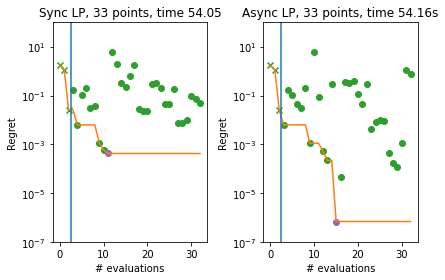

In [10]:
from util.plotting import plot_regret
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

sync_lp_min_idx = tf.squeeze(tf.argmin(sync_lp_observations, axis=0))
async_lp_min_idx = tf.squeeze(tf.argmin(async_lp_observations, axis=0))

plot_regret(
    sync_lp_observations.numpy(),
    ax[0],
    num_init=len(initial_data),
    idx_best=sync_lp_min_idx,
)
ax[0].set_yscale("log")
ax[0].set_ylabel("Regret")
ax[0].set_ylim(0.0000001, 100)
ax[0].set_xlabel("# evaluations")
ax[0].set_title(
    f"Sync LP, {len(sync_lp_observations)} points, time {sync_lp_time:.2f}"
)

plot_regret(
    async_lp_observations.numpy(),
    ax[1],
    num_init=len(initial_data),
    idx_best=async_lp_min_idx,
)
ax[1].set_yscale("log")
ax[1].set_ylabel("Regret")
ax[1].set_ylim(0.0000001, 100)
ax[1].set_xlabel("# evaluations")
ax[1].set_title(
    f"Async LP, {len(async_lp_observations)} points, time {async_lp_time:.2f}s"
)

fig.tight_layout()